In [1]:
import pandas as pd
import numpy as np
import holidays
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('data/Ad Sales Performance.csv')
df["Date"] = pd.to_datetime(df["Date"])
df.head()

,Date,Ad Sales,Ad Spend,Ad Clicks,Organic Sales,ACOS %,ROAS,T-ACOS %,CPC,Ad CVR %,Ad CTR %,Ad CPA,Organic Sales %,Ad Sales %
0,2024-03-01,0.0,0.0,0.0,124600.76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2024-03-02,0.0,0.0,0.0,131626.54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2024-03-03,0.0,0.0,0.0,146116.23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2024-03-04,0.0,0.0,0.0,130231.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2024-03-05,0.0,0.0,0.0,163783.57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [3]:
# Data Preprocessing
data = df.copy()

# decide month interval
data['month'] = pd.cut(data["Date"].dt.day, bins=[0, 10, 20, 31], labels=["early", "mid", "late"])
data = pd.get_dummies(data, columns=['month'])

# decide is weekend
data['is_weekend'] = data['Date'].dt.weekday >= 5

# decide is holiday
us_holidays = holidays.UnitedStates(years=[2024, 2025])
data['is_holiday'] = data['Date'].apply(lambda x: x in us_holidays)

# choose after 2024-08-10
data = data[data['Date'] > '2024-08-10']

# Process date time
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['DayOfWeek'] = data['Date'].dt.weekday  # 0 = Monday, 6 = Sunday

# data = data.reset_index(drop=True)
data.set_index('Date', inplace=True)

In [4]:
features = ['Year', 'Month', 'Day', 'DayOfWeek', 'Ad Spend', 'is_weekend', 'is_holiday', 'month_early', 'month_mid', 'month_late']
target = ['Ad Sales', 'Ad Clicks']

X = data[features]
y = data[target]

split_index = int(data.shape[0] * 0.8)
X_train = X.iloc[:split_index, :]
X_test = X.iloc[split_index:, :]
y_train = y.iloc[:split_index, :]
y_test = y.iloc[split_index:, :]

In [12]:
def plot_predict(y_test, y_pred_df):
    plt.figure(figsize=(9, 4.5))

    for col in y_test.columns:
        plt.plot(y_test.index, y_test[col], label=f"Actual {col}", linestyle='dashed', linewidth=3)
        plt.plot(y_test.index, y_pred_df[col], label=f"Predicted {col}", linewidth=3.5)

    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.title("Actual vs Predicted Sales & Clicks")
    plt.legend()
    plt.show()

Mean Squared Error (MSE): 1197176.98
R² Score: 0.50


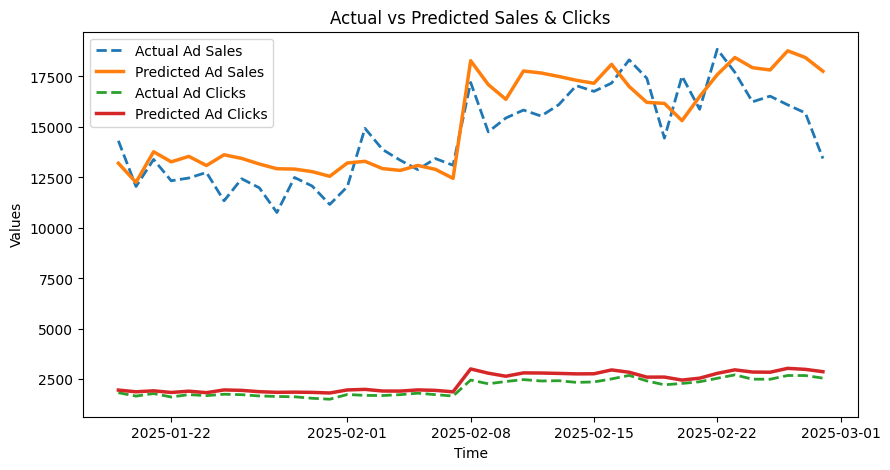

In [6]:
model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_df = pd.DataFrame(y_pred, columns=y_test.columns, index=y_test.index)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")

plot_predict(y_test, y_pred_df)

XGBoost MSE: 1042941.06
XGBoost R² Score: 0.56


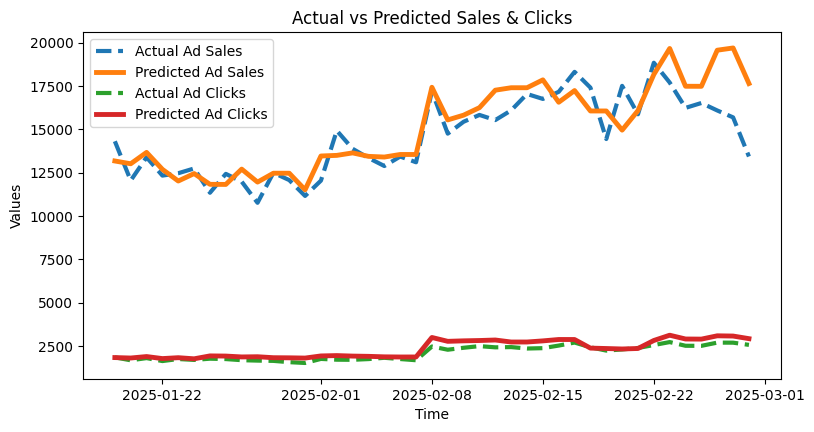

In [13]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_pred_df = pd.DataFrame(y_pred_xgb, columns=y_test.columns, index=y_test.index)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost MSE: {mse_xgb:.2f}")
print(f"XGBoost R² Score: {r2_xgb:.2f}")

plot_predict(y_test, y_pred_df)

In [157]:
data = data.sort_values(by=['Year', 'Month', 'Day'])

X = data[features].values
y = data[target].values

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

lookback = 7  # Use past 7 date as predict data

def create_sequences(X, y, lookback):
    X_seq, y_seq = [], []
    for i in range(len(X) - lookback):
        X_seq.append(X[i:i+lookback])
        y_seq.append(y[i+lookback])  # predict future 1 day
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, lookback)

split_index = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_index], X_seq[split_index:]
y_train, y_test = y_seq[:split_index], y_seq[split_index:]

In [120]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(lookback, X_train.shape[2])),
    Dropout(0.2), 
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),  
    Dense(y_train.shape[1])
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=60, batch_size=16, validation_data=(X_test, y_test), verbose=1)

Epoch 1/60


/Users/zoe/Documents/Program/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1211 - val_loss: 0.0123
Epoch 2/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0552 - val_loss: 0.0072
Epoch 3/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0403 - val_loss: 0.0133
Epoch 4/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0507 - val_loss: 0.0077
Epoch 5/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0384 - val_loss: 0.0087
Epoch 6/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0343 - val_loss: 0.0063
Epoch 7/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0299 - val_loss: 0.0042
Epoch 8/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0383 - val_loss: 0.0067
Epoch 9/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0365 - val_loss: 0.0047
Epoch 10/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0301 - val_loss: 0.0034
Epoch 11/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0315 - val_loss: 0.0042
Epoch 12/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0275 - val_loss: 0.0083

In [ ]:
# 預測測試集數據
y_pred_scaled = model.predict(X_test)

# 反向縮放數據，恢復原始值
y_pred_lstm = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

# 轉換為 DataFrame
y_pred_df = pd.DataFrame(y_pred_lstm, columns=['Ad Sales', 'Ad Clicks'])
y_test_df = pd.DataFrame(y_test_actual, columns=['Ad Sales', 'Ad Clicks'])

# 添加日期索引
y_pred_df.index = data.index[-len(y_pred_df):]
y_test_df.index = data.index[-len(y_test_df):]

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/stepWARNING:tensorflow:6 out of the last 8 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x30c2b2520> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


LSTM MSE: 2204899.74
LSTM R² Score: 0.32


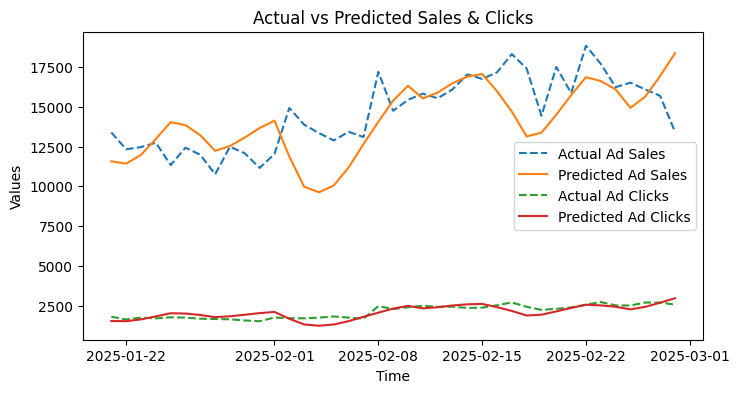

In [122]:
mse_lstm = mean_squared_error(y_test_actual, y_pred_lstm)
r2_lstm = r2_score(y_test_actual, y_pred_lstm)

print(f"LSTM MSE: {mse_lstm:.2f}")
print(f"LSTM R² Score: {r2_lstm:.2f}")

plot_predict(y_test_df, y_pred_df)